In [332]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

In [363]:
import pandas
cars = pandas.read_csv("./car-prices.data", names=["symboling",
                                                "normalized-losses",
                                                "make",
                                                "fuel-type",
                                                "aspriation",
                                                "num-of-doors",
                                                "body-style",
                                                "drive-wheels",
                                                "engine-location",
                                                "wheel-base",
                                                "length",
                                                "width",
                                                "height",
                                                "curb-weight",
                                                "engine-type",
                                                "num-of-cylinders",
                                                "engine-size",
                                                "fuel-system",
                                                "bore",
                                                "stroke",
                                                "compression-ratio",
                                                "horsepower",
                                                "peak-rpm",
                                                "city-mpg",
                                                "highway-mpg",
                                                "price",],
                      na_values="?")

In [364]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspriation         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

## Database preparation

In [365]:
target = "price"
number_dict = {"two": 2, "four": 4, "six": 6, "eight": 8, "twelve": 12, "three": 3, "five": 5}
cars[target].describe()

count      201.000000
mean     13207.129353
std       7947.066342
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16500.000000
max      45400.000000
Name: price, dtype: float64

In [366]:
def clean_df(df: pandas.DataFrame) -> pandas.DataFrame:
    text_to_num_cols = ["num-of-doors", "num-of-cylinders"]
    df = df.copy()
    for col in text_to_num_cols:
        df[col] = df[col].map(number_dict)
    df = df.drop(["normalized-losses"], axis=1)
    df = df.dropna(subset=["price" , "horsepower", ]) 
    df = df.fillna(df.mode().loc[0])
    df = df.sample(frac=1, random_state=1)
    return df

clean_cars = clean_df(cars)
clean_cars.info()
clean_cars.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 181 to 38
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          199 non-null    int64  
 1   make               199 non-null    object 
 2   fuel-type          199 non-null    object 
 3   aspriation         199 non-null    object 
 4   num-of-doors       199 non-null    float64
 5   body-style         199 non-null    object 
 6   drive-wheels       199 non-null    object 
 7   engine-location    199 non-null    object 
 8   wheel-base         199 non-null    float64
 9   length             199 non-null    float64
 10  width              199 non-null    float64
 11  height             199 non-null    float64
 12  curb-weight        199 non-null    int64  
 13  engine-type        199 non-null    object 
 14  num-of-cylinders   199 non-null    int64  
 15  engine-size        199 non-null    int64  
 16  fuel-system        199 no

,symboling,make,fuel-type,aspriation,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
181,-1,toyota,gas,std,4.0,wagon,rwd,front,104.5,187.8,...,161,mpfi,3.27,3.35,9.2,156.0,5200.0,19,24,15750.0
41,0,honda,gas,std,4.0,sedan,fwd,front,96.5,175.4,...,110,mpfi,3.15,3.58,9.0,101.0,5800.0,24,28,12945.0
35,0,honda,gas,std,4.0,sedan,fwd,front,96.5,163.4,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,30,34,7295.0
93,1,nissan,gas,std,4.0,wagon,fwd,front,94.5,170.2,...,97,2bbl,3.15,3.29,9.4,69.0,5200.0,31,37,7349.0
151,1,toyota,gas,std,2.0,hatchback,fwd,front,95.7,158.7,...,92,2bbl,3.05,3.03,9.0,62.0,4800.0,31,38,6338.0


## Selection of potential features


In [367]:
min_correlation = 0.1
correlations = clean_cars.corr()[target].abs().sort_values(ascending=False)
potential_features = correlations[(correlations > min_correlation) & (correlations < 1)].index

## Function to find root of mean squared error

In [458]:
def rmse(df, features, target="price", neighbours=5):
    kfold = KFold(n_splits=5)
    RMSES = []
    model = KNeighborsRegressor(n_neighbors=neighbours)
    for train_ind, test_ind in kfold.split(df):
        model.fit(df.iloc[train_ind][features], df.iloc[train_ind][target])
        prediction = model.predict(df.iloc[test_ind][features])
        RMSE = mean_squared_error(prediction, df.iloc[test_ind][target]) ** (1/2)
        RMSES.append(RMSE)
    return int(np.mean(RMSES))

## Univariate model selection

In [460]:
feature_dict = {}
for feature in potential_features:
    feature_dict[feature] = rmse(clean_cars, [feature])
    
sorted_features = pandas.Series(feature_dict, name="RMSE").sort_values()
best_six_features = sorted_features[:6]
best_six_features

engine-size    3231
horsepower     3733
curb-weight    4071
highway-mpg    4177
city-mpg       4226
width          4260
Name: RMSE, dtype: int64

### Dependance of number of neighbours:

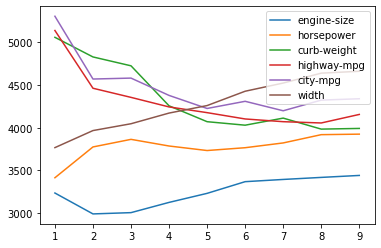

In [454]:
data = {}
for feature in best_six_features.index:
    data[feature] = {k: rmse(clean_cars, [feature], neighbours=k) for k in range(1, 10)}
    
for feature, rmses in data.items():
    plt.plot(rmses.keys(), rmses.values(), label=feature)

plt.legend()
plt.show()

Best univariate model will be based on `engine-size` with 2 or 3 neighbours used when training the model

## Multivariate model
Let's check error for all possible combinations of six best features predicting the price:

In [456]:
import itertools
all_combinations = []
for k in range(1,len(best_six_features)+1):
    a = list(itertools.combinations(best_six_features.index, k))
    all_combinations.extend(a)
all_combinations[:10]

[('engine-size',),
 ('horsepower',),
 ('curb-weight',),
 ('highway-mpg',),
 ('city-mpg',),
 ('width',),
 ('engine-size', 'horsepower'),
 ('engine-size', 'curb-weight'),
 ('engine-size', 'highway-mpg'),
 ('engine-size', 'city-mpg')]

In [457]:
rmses = []
for features in all_combinations:
    for k in range(1, 10):
        rmses.append((features, k, rmse(clean_cars, list(features), neighbours=k)))
rmses.sort(key=lambda k: k[2])
rmses

[(('engine-size', 'city-mpg'), 2, 2568),
 (('engine-size', 'highway-mpg', 'city-mpg', 'width'), 3, 2612),
 (('engine-size', 'city-mpg'), 3, 2624),
 (('engine-size', 'city-mpg', 'width'), 2, 2624),
 (('engine-size', 'highway-mpg', 'city-mpg', 'width'), 2, 2646),
 (('engine-size', 'horsepower', 'city-mpg', 'width'), 2, 2652),
 (('engine-size', 'highway-mpg', 'city-mpg'), 3, 2664),
 (('engine-size', 'horsepower', 'highway-mpg', 'city-mpg', 'width'), 2, 2665),
 (('engine-size', 'highway-mpg', 'width'), 3, 2676),
 (('engine-size', 'horsepower', 'highway-mpg', 'width'), 2, 2682),
 (('engine-size', 'highway-mpg', 'width'), 2, 2690),
 (('engine-size', 'highway-mpg', 'city-mpg'), 2, 2691),
 (('engine-size', 'horsepower', 'city-mpg'), 2, 2697),
 (('engine-size', 'horsepower', 'width'), 2, 2700),
 (('engine-size', 'horsepower', 'highway-mpg', 'city-mpg'), 2, 2716),
 (('engine-size', 'horsepower', 'highway-mpg'), 2, 2717),
 (('engine-size', 'highway-mpg'), 2, 2724),
 (('engine-size', 'horsepower',

Prices are best predicted with `engine-size` and `city-mpg` features using 2 closest neighbours.
For a more feature-rich model, one can use `engine-size`, `city-mpg`, `highway-mpg` and `width` and set the model to find three closest neighbours.